<a href="https://colab.research.google.com/github/kridtapon/HMA-EFI-Trend-Reversal-System/blob/main/HMA_EFI_Trend_Reversal_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 33.7 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.7/108.7 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.52
    Uninstalling yfinance-0.2.52:
      Successfully uninstalled yfinance-0.2.52


In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate Hull Moving Average (HMA)
def calculate_hma(series, period=20):
    """
    Calculate Hull Moving Average.
    """
    wma_half = series.rolling(window=int(period / 2)).mean()
    wma_full = series.rolling(window=period).mean()
    hma = (2 * wma_half - wma_full).rolling(window=int(np.sqrt(period))).mean()
    return hma

# Function to calculate Elder's Force Index (EFI)
def calculate_efi(df, period=13):
    """
    Calculate Elder's Force Index (EFI).
    """
    efi = (df['Close'].diff() * df['Volume']).ewm(span=period).mean()
    return efi

# Define stock symbol and time period
symbol = 'META'  # Example stock
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Calculate HMA and EFI
df['HMA'] = calculate_hma(df['Close'], period=20)
df['EFI'] = calculate_efi(df, period=13)

# Filter data for test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Define Entry and Exit signals based on HMA and EFI
df['Entry'] = (df['HMA'] > df['HMA'].shift(10)) & (df['EFI'] > 0)
df['Exit'] = (df['HMA'] < df['HMA'].shift(10)) | (df['EFI'] < df['EFI'].shift(30))

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sharpe_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'calmar_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'omega_ratio' requires frequency to be set
  warnings.warn(warning_message)
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning: Metric 'sortino_ratio' requires frequency to be set
  warnings.warn(warning_message)


Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                            93926.920492
Total Return [%]                         -6.07308
Benchmark Return [%]                   180.172856
Max Gross Exposure [%]                      100.0
Total Fees Paid                      10257.518209
Max Drawdown [%]                        68.848764
Max Drawdown Duration                      1097.0
Total Trades                                   63
Total Closed Trades                            63
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            42.857143
Best Trade [%]                          38.353694
Worst Trade [%]                        -15.703036
Avg Winning Trade [%]                    6.494752
Avg Losing Trade [%]                    -4.479145


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools

# Function to calculate Hull Moving Average (HMA)
def calculate_hma(series, period):
    wma_half = series.rolling(window=int(period / 2)).mean()
    wma_full = series.rolling(window=period).mean()
    hma = (2 * wma_half - wma_full).rolling(window=int(np.sqrt(period))).mean()
    return hma

# Function to calculate Elder's Force Index (EFI)
def calculate_efi(df, period):
    efi = (df['Close'].diff() * df['Volume']).ewm(span=period).mean()
    return efi

# Define stock symbol and time period
symbol = 'META'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define parameter ranges
hma_periods = range(10, 51, 5)  # HMA periods from 10 to 50 in steps of 5
efi_periods = range(5, 31, 5)    # EFI periods from 5 to 30 in steps of 5

best_params = None
best_return = float('-inf')

# Iterate over all parameter combinations
for hma_period, efi_period in itertools.product(hma_periods, efi_periods):
    df['HMA'] = calculate_hma(df['Close'], hma_period)
    df['EFI'] = calculate_efi(df, efi_period)

    # Filter data for test period
    df_filter = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    df_filter['Entry'] = (df_filter['HMA'] > df_filter['HMA'].shift(10)) & (df_filter['EFI'] > 0)
    df_filter['Exit'] = (df_filter['HMA'] < df_filter['HMA'].shift(10)) | (df_filter['EFI'] < df_filter['EFI'].shift(30))

    portfolio = vbt.Portfolio.from_signals(
        close=df_filter['Close'],
        entries=df_filter['Entry'],
        exits=df_filter['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    total_return = portfolio.total_return()
    if total_return > best_return:
        best_return = total_return
        best_params = (hma_period, efi_period)

    print(f"HMA: {hma_period}, EFI: {efi_period}, Total Return: {total_return:.2%}")

print(f"Best Parameters: HMA = {best_params[0]}, EFI = {best_params[1]}, Best Return: {best_return:.2%}")


[*********************100%***********************]  1 of 1 completed
<ipython-input-4-78ddb800f37c>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['Entry'] = (df_filter['HMA'] > df_filter['HMA'].shift(10)) & (df_filter['EFI'] > 0)
<ipython-input-4-78ddb800f37c>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['Exit'] = (df_filter['HMA'] < df_filter['HMA'].shift(10)) | (df_filter['EFI'] < df_filter['EFI'].shift(30))
<ipython-input-4-78ddb800f37c>:43: SettingWithCopyWarning: 
A value i

HMA: 10, EFI: 5, Total Return: -37.33%
HMA: 10, EFI: 10, Total Return: 45.15%
HMA: 10, EFI: 15, Total Return: 56.48%
HMA: 10, EFI: 20, Total Return: 48.72%
HMA: 10, EFI: 25, Total Return: 18.64%
HMA: 10, EFI: 30, Total Return: 22.38%
HMA: 15, EFI: 5, Total Return: -16.67%
HMA: 15, EFI: 10, Total Return: 119.26%
HMA: 15, EFI: 15, Total Return: 94.93%
HMA: 15, EFI: 20, Total Return: 74.63%
HMA: 15, EFI: 25, Total Return: 38.65%
HMA: 15, EFI: 30, Total Return: 42.00%
HMA: 20, EFI: 5, Total Return: -10.08%
HMA: 20, EFI: 10, Total Return: 90.49%
HMA: 20, EFI: 15, Total Return: 52.27%
HMA: 20, EFI: 20, Total Return: 67.75%


<ipython-input-4-78ddb800f37c>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['Entry'] = (df_filter['HMA'] > df_filter['HMA'].shift(10)) & (df_filter['EFI'] > 0)
<ipython-input-4-78ddb800f37c>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['Exit'] = (df_filter['HMA'] < df_filter['HMA'].shift(10)) | (df_filter['EFI'] < df_filter['EFI'].shift(30))
<ipython-input-4-78ddb800f37c>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

HMA: 20, EFI: 25, Total Return: 50.22%
HMA: 20, EFI: 30, Total Return: 70.88%
HMA: 25, EFI: 5, Total Return: -4.29%
HMA: 25, EFI: 10, Total Return: 96.66%
HMA: 25, EFI: 15, Total Return: 47.51%
HMA: 25, EFI: 20, Total Return: 57.89%
HMA: 25, EFI: 25, Total Return: 52.89%
HMA: 25, EFI: 30, Total Return: 86.44%
HMA: 30, EFI: 5, Total Return: -20.55%
HMA: 30, EFI: 10, Total Return: 65.98%
HMA: 30, EFI: 15, Total Return: 35.48%
HMA: 30, EFI: 20, Total Return: 21.14%
HMA: 30, EFI: 25, Total Return: 20.03%
HMA: 30, EFI: 30, Total Return: 67.78%
HMA: 35, EFI: 5, Total Return: -12.68%
HMA: 35, EFI: 10, Total Return: 41.53%
HMA: 35, EFI: 15, Total Return: 21.84%


<ipython-input-4-78ddb800f37c>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['Entry'] = (df_filter['HMA'] > df_filter['HMA'].shift(10)) & (df_filter['EFI'] > 0)
<ipython-input-4-78ddb800f37c>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['Exit'] = (df_filter['HMA'] < df_filter['HMA'].shift(10)) | (df_filter['EFI'] < df_filter['EFI'].shift(30))
<ipython-input-4-78ddb800f37c>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

HMA: 35, EFI: 20, Total Return: 18.32%
HMA: 35, EFI: 25, Total Return: 10.08%
HMA: 35, EFI: 30, Total Return: 56.97%
HMA: 40, EFI: 5, Total Return: -5.98%
HMA: 40, EFI: 10, Total Return: 53.17%
HMA: 40, EFI: 15, Total Return: 31.26%
HMA: 40, EFI: 20, Total Return: 23.99%
HMA: 40, EFI: 25, Total Return: 24.20%
HMA: 40, EFI: 30, Total Return: 51.15%
HMA: 45, EFI: 5, Total Return: 2.38%
HMA: 45, EFI: 10, Total Return: 80.61%
HMA: 45, EFI: 15, Total Return: 64.61%
HMA: 45, EFI: 20, Total Return: 61.85%
HMA: 45, EFI: 25, Total Return: 73.36%
HMA: 45, EFI: 30, Total Return: 81.62%
HMA: 50, EFI: 5, Total Return: 28.13%
HMA: 50, EFI: 10, Total Return: 108.95%
HMA: 50, EFI: 15, Total Return: 92.45%
HMA: 50, EFI: 20, Total Return: 74.86%
HMA: 50, EFI: 25, Total Return: 99.72%
HMA: 50, EFI: 30, Total Return: 104.78%
Best Parameters: HMA = 15, EFI = 10, Best Return: 119.26%


<ipython-input-4-78ddb800f37c>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['Exit'] = (df_filter['HMA'] < df_filter['HMA'].shift(10)) | (df_filter['EFI'] < df_filter['EFI'].shift(30))
<ipython-input-4-78ddb800f37c>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['Entry'] = (df_filter['HMA'] > df_filter['HMA'].shift(10)) & (df_filter['EFI'] > 0)
<ipython-input-4-78ddb800f37c>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Streaming output truncated to the last 5000 lines.
<ipython-input-15-fc264591b7f0>:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-fc264591b7f0>:46: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-15-fc264591b7f0>:47: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ret

Best Parameters: HMA = 19, EFI = 12, Best Return: 68.03%


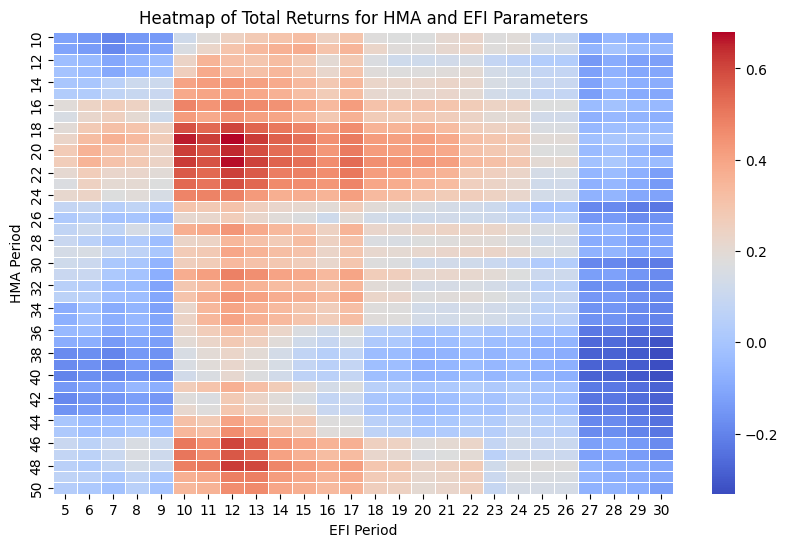

In [15]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# Function to calculate Hull Moving Average (HMA)
def calculate_hma(series, period):
    wma_half = series.rolling(window=int(period / 2)).mean()
    wma_full = series.rolling(window=period).mean()
    hma = (2 * wma_half - wma_full).rolling(window=int(np.sqrt(period))).mean()
    return hma

# Function to calculate Elder's Force Index (EFI)
def calculate_efi(df, period):
    efi = (df['Close'].diff() * df['Volume']).ewm(span=period).mean()
    return efi

# Define stock symbol and time period
symbol = 'MMM'
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Define parameter ranges
hma_periods = range(10, 51)  # HMA periods from 10 to 50
efi_periods = range(5, 31)    # EFI periods from 5 to 30

best_params = None
best_return = float('-inf')
results = []

# Iterate over all parameter combinations
for hma_period, efi_period in itertools.product(hma_periods, efi_periods):
    df['HMA'] = calculate_hma(df['Close'], hma_period)
    df['EFI'] = calculate_efi(df, efi_period)

    # Filter data for test period
    df_filter = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

    df_filter['Entry'] = (df_filter['HMA'] > df_filter['HMA'].shift(5)) & (df_filter['EFI'] > 0)
    df_filter['Exit'] = (df_filter['HMA'] < df_filter['HMA'].shift(5)) | (df_filter['EFI'] < df_filter['EFI'].shift(15))

    portfolio = vbt.Portfolio.from_signals(
        close=df_filter['Close'],
        entries=df_filter['Entry'],
        exits=df_filter['Exit'],
        init_cash=100_000,
        fees=0.001
    )

    total_return = portfolio.total_return()
    results.append((hma_period, efi_period, total_return))

    if total_return > best_return:
        best_return = total_return
        best_params = (hma_period, efi_period)

print(f"Best Parameters: HMA = {best_params[0]}, EFI = {best_params[1]}, Best Return: {best_return:.2%}")

# Create a heatmap dataframe
heatmap_data = pd.DataFrame(index=hma_periods, columns=efi_periods)
for hma_period, efi_period, total_return in results:
    heatmap_data.loc[hma_period, efi_period] = total_return

heatmap_data = heatmap_data.astype(float)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=False, fmt=".2%", cmap="coolwarm", linewidths=0.5)
plt.xlabel("EFI Period")
plt.ylabel("HMA Period")
plt.title("Heatmap of Total Returns for HMA and EFI Parameters")
plt.show()

In [16]:
# Calculate HMA and EFI
df['HMA'] = calculate_hma(df['Close'], period=19)
df['EFI'] = calculate_efi(df, period=12)

# Filter data for test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Define Entry and Exit signals based on HMA and EFI
df['Entry'] = (df['HMA'] > df['HMA'].shift(5)) & (df['EFI'] > 0)
df['Exit'] = (df['HMA'] < df['HMA'].shift(5)) | (df['EFI'] < df['EFI'].shift(15))

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=df['Entry'],
    exits=df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

<ipython-input-16-8b5c3aa6a071>:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-16-8b5c3aa6a071>:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/st

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           168033.804092
Total Return [%]                        68.033804
Benchmark Return [%]                     4.984507
Max Gross Exposure [%]                      100.0
Total Fees Paid                       8647.840119
Max Drawdown [%]                         18.18015
Max Drawdown Duration                       602.0
Total Trades                                   38
Total Closed Trades                            38
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            31.578947
Best Trade [%]                          21.047971
Worst Trade [%]                         -4.477248
Avg Winning Trade [%]                    8.957478
Avg Losing Trade [%]                    -1.831695
